In [1]:
'''%pip install pandas matplotlib seaborn tensorflow snowflake-connector-python imbalanced-learn scikit-learn langdetect transformers tensorflow-hub keras scikit-optimize xgboost nltk sentencepiece sacremoses '''

'%pip install pandas matplotlib seaborn tensorflow snowflake-connector-python imbalanced-learn scikit-learn langdetect transformers tensorflow-hub keras scikit-optimize xgboost nltk sentencepiece sacremoses '

In [3]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import snowflake.connector
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import langdetect
import re
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, TFBertModel
import numpy as n
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from multiprocessing import Pool, cpu_count

In [2]:
conn = snowflake.connector.connect(
    user='ykhalifa',
    password='Youssef-2411',
    account='fq42011.west-europe.azure',
    warehouse='PROD_WH',
    database='PROPERTIES_DWH_EG',
    schema='VW_XXEMR_MONTH_COMPLAINTS_V'
)

In [3]:
cur = conn.cursor()

# Execute a SQL query
sql = "SELECT * FROM PRODUCTION.PROPERTIES_DWH_EG.VW_XXEMR_MONTH_COMPLAINTS_V"
cur.execute(sql)

In [4]:
# Fetch the data into a Pandas DataFrame
df = cur.fetch_pandas_all()

# Close the cursor and connection
cur.close()
conn.close()

In [5]:
#Filtering the Data By CAll TYPE , Problem Code not null and isn't mobile app registration 
df = df[(df['CALL_TYPE'] == "Complaint") & (((~df['PROBLEM_CODE'].str.contains("Mobile", regex=False, na=False))) &(df['PROBLEM_CODE'].notna()))]
df = df[df['PROJECT'].notna()]

In [7]:
#Dropping Un-Needed Columns
df.drop(['CALL_TYPE', 'LOCATION_CODE','SERVICE_PROVIDER','PROBLEM_CATEGORY_LEVEL_2',
       'PROBLEM_CATEGORY_LEVEL_1','NEW_INCIDENT_STATUS','INCIDENT_STATUS','INCIDENT_NUMBER','PROBLEM_CODE_SUMMARY'], axis=1,inplace=True)

In [4]:
df = pd.read_csv(r"/home/azureuser/cloudfiles/code/a_df.csv")

In [5]:
df = df.loc[:, ['PROBLEM_SUMMARY', 'PROBLEM_CODE']]

In [6]:
df

,PROBLEM_SUMMARY,PROBLEM_CODE
0,client name Gamila call us The client complain...,Neighbor Noise
1,the client complains many times about his Neig...,Neighbor Noise
2,the client complains that his neighbor in Mara...,Neighbor Noise
3,Caller Alia Request Client is complaining fr...,Neighbor Noise
4,Who calledMoheb What did they request The cust...,Neighbor Noise
...,...,...
26806,"Caller: Saif, Request: Lost parking ticket, ...",RO- Events Parking Issues
26807,"Caller: Hend, Request: Parking gate malfunct...",RO- Events Parking Issues
26808,"Caller: Ahmad, Request: Request for a design...",RO- Events Parking Issues
26809,"Caller: Lamia, Request: Need for improved ma...",RO- Events Parking Issues


In [7]:
#Dropping Problem Codes with less than 10 instances 

class_counts = df['PROBLEM_CODE'].value_counts()

# Step 2: Identify the classes that have more than 10 instances
valid_classes = class_counts[class_counts > 10].index

# Step 3: Filter the DataFrame to keep only the valid classes
df_filtered = df[df['PROBLEM_CODE'].isin(valid_classes)]
df = df_filtered 

In [8]:
#Cleaning Data From Arabic/Other langauges  Instances
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except:
        return None 

df['language'] = df['PROBLEM_SUMMARY'].apply(detect_language)
df_clean = df[df['language'] == 'en']

In [9]:
df_clean

,PROBLEM_SUMMARY,PROBLEM_CODE,language
0,client name Gamila call us The client complain...,Neighbor Noise,en
1,the client complains many times about his Neig...,Neighbor Noise,en
2,the client complains that his neighbor in Mara...,Neighbor Noise,en
3,Caller Alia Request Client is complaining fr...,Neighbor Noise,en
4,Who calledMoheb What did they request The cust...,Neighbor Noise,en
...,...,...,...
26806,"Caller: Saif, Request: Lost parking ticket, ...",RO- Events Parking Issues,en
26807,"Caller: Hend, Request: Parking gate malfunct...",RO- Events Parking Issues,en
26808,"Caller: Ahmad, Request: Request for a design...",RO- Events Parking Issues,en
26809,"Caller: Lamia, Request: Need for improved ma...",RO- Events Parking Issues,en


In [10]:
#Removing the numbers , punctuation and whitespaces
def clean_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove Special shit 
    text = re.sub(r'[^\w\s]', '', text)  
    # Remove extra whitespace
    text = text.strip()
    return text

df_clean['PROBLEM_SUMMARY'] = df_clean['PROBLEM_SUMMARY'].apply(clean_text)

/tmp/ipykernel_6761/1744790155.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['PROBLEM_SUMMARY'] = df_clean['PROBLEM_SUMMARY'].apply(clean_text)


In [11]:
df_clean = df_clean.drop('language',axis=1)

In [12]:
class_counts = df_clean['PROBLEM_CODE'].value_counts()
classes_to_drop = class_counts[class_counts < 2].index
df_clean = df_clean[~df_clean['PROBLEM_CODE'].isin(classes_to_drop)]

In [13]:
label_encoder = LabelEncoder()
df_clean['PROBLEM_CODE'] = label_encoder.fit_transform(df_clean['PROBLEM_CODE'])
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print(label_mapping)

{0: 'AC', 1: 'AC_DLP', 2: 'Access Control', 3: 'Access Control - Facility Management', 4: 'Access Permission', 5: 'Access Permission - MSA', 6: 'Access Permission - MVD', 7: 'Access Permission - UTC', 8: 'Aluminum', 9: 'Aluminum_DLP', 10: 'Attitude', 11: 'Blacksmith', 12: 'Business proposal', 13: 'CM Office', 14: 'Call Center internal escalation', 15: 'Careers', 16: 'Carpentry', 17: 'Carpentry-DLP', 18: 'Check Collection', 19: 'Check Up Call', 20: 'Cheque Resubmission', 21: 'Civil', 22: 'Civil-DLP', 23: 'Cleaning', 24: 'Clients follow up on their requests within SLA', 25: 'Collection Complaint', 26: 'Common Area enhancement', 27: 'Community Center', 28: 'Community Rules', 29: 'Community Violation', 30: 'Construction', 31: 'Contractors Violation', 32: 'Customer Data update', 33: 'Data Violation', 34: 'Delay Penalty', 35: 'Delivery Cheque Collection Inquiry', 36: 'Design Dispute', 37: 'Dues Inquiries', 38: 'Early Handover Request', 39: 'Electrical', 40: 'Electrical-DLP', 41: 'Elevators',

In [14]:
print("Max label in y:", df_clean['PROBLEM_CODE'].max())
Num_Classes = df_clean['PROBLEM_CODE'].max() + 1

Max label in y: 133


In [15]:
# Bert Initilization 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
data = df_clean['PROBLEM_SUMMARY']
df = pd.DataFrame(data)

2024-11-26 11:55:53.648961: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClass

In [16]:
import pandas as pd
import numpy as np
from collections import Counter
from nltk.corpus import wordnet
from transformers import pipeline
import random
from tqdm import tqdm
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4') 

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [20]:
import pandas as pd
import random

def limit_classes_to_max_samples(df, target, max_samples=200):
    """
    Limit the number of samples in each class to the given maximum (e.g., 200).
    
    Args:
    - df: The input DataFrame.
    - target: The column name that contains the class labels.
    - max_samples: The maximum number of samples to retain per class.
    
    Returns:
    - A DataFrame with the classes limited to the specified number of samples.
    """
    # Create a list to hold the filtered rows
    filtered_data = []
    
    # Get class counts
    class_counts = df[target].value_counts()
    
    # Process each class
    for class_label, count in class_counts.items():
        class_data = df[df[target] == class_label]
        
        # If the class has more than max_samples, sample random rows
        if count > max_samples:
            sampled_data = class_data.sample(n=max_samples, random_state=42)
        else:
            sampled_data = class_data
        
        # Append the class data (sampled or original) to the list
        filtered_data.append(sampled_data)
    
    # Combine all the filtered data into a single DataFrame
    limited_df = pd.concat(filtered_data, ignore_index=True)
    return limited_df

# Example usage:
df = df_clean  # Replace with your actual DataFrame
target = 'PROBLEM_CODE'  # Your target column (problem code/category)

# Apply the function to limit the class sizes
limited_df = limit_classes_to_max_samples(df, target, max_samples=200)

# Print results
print("Original class distribution:")
print(df[target].value_counts())

print("\nClass distribution after limiting to 200 samples per class:")
print(limited_df[target].value_counts())


Original class distribution:
PROBLEM_CODE
70     4226
28     3458
119    1995
10     1511
75     1295
       ... 
47       12
116      11
19       11
132      10
42       10
Name: count, Length: 134, dtype: int64

Class distribution after limiting to 200 samples per class:
PROBLEM_CODE
70     200
28     200
119    200
10     200
75     200
      ... 
47      12
116     11
19      11
132     10
42      10
Name: count, Length: 134, dtype: int64


In [ ]:
label_mapping 

In [33]:
# Step 1: Calculate the count of each class
class_counts = limited_df['PROBLEM_CODE'].value_counts()

# Step 2: Identify the classes that have fewer than 100 instances
invalid_classes = class_counts[class_counts < 200]

# Step 3: Map the encoded problem codes to their decoded names using the label_mapping
decoded_invalid_classes = invalid_classes.index.map(label_mapping)

# Convert to a Series to allow to_csv export
decoded_invalid_classes = pd.Series(decoded_invalid_classes)

# Step 4: Save the decoded class names to a CSV file
decoded_invalid_classes.to_csv("invalid_Classes.csv", index=False, header=["Decoded_Classes"])


In [25]:
lim_df = pd.DataFrame()
# Assuming the column to decode is 'encoded_column' and you have the 'label_mapping' dictionary
lim_df['PROBLEM_CODE'] = limited_df['PROBLEM_CODE'].map(label_mapping)
lim_df['PROBLEM_SUMMARY'] = limited_df['PROBLEM_SUMMARY']
# Now export to CSV
lim_df.to_csv("Limited_Table.csv", index=False)

In [ ]:
#Removing the numbers , punctuation and whitespaces
def clean_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove Special shit 
    text = re.sub(r'[^\w\s]', '', text)  
    # Remove extra whitespace
    text = text.strip()
    return text

limited_df['PROBLEM_SUMMARY'] = limited_df['PROBLEM_SUMMARY'].apply(clean_text)

In [ ]:
import multiprocessing
from functools import partial

In [ ]:
import pandas as pd
import random
from nltk.corpus import wordnet
from tqdm import tqdm
from transformers import pipeline
import nltk

# Ensure necessary NLTK resources are downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize translation pipeline
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-de")
back_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-de-en")


# Precompute synonyms for faster lookup
precomputed_synonyms = {}

def get_synonyms(word):
    if word not in precomputed_synonyms:
        synonyms = wordnet.synsets(word)
        precomputed_synonyms[word] = [syn.lemma_names()[0] for syn in synonyms if syn.lemma_names()]
    return precomputed_synonyms[word]

def optimized_synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    random_words = list(set(words))
    random.shuffle(random_words)
    
    num_replaced = 0
    for word in random_words:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            if synonym != word:
                new_words = [synonym if w == word else w for w in new_words]
                num_replaced += 1
            if num_replaced >= n:
                break
    return ' '.join(new_words)

# Synonym replacement function
def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    random_words = list(set(words))
    random.shuffle(random_words)
    
    num_replaced = 0
    for word in random_words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemma_names()[0]
            if synonym != word:
                new_words = [synonym if w == word else w for w in new_words]
                num_replaced += 1
            if num_replaced >= n:
                break
    return ' '.join(new_words)

# Back-translation function
def back_translate(text):
    try:
        german = translator(text)[0]['translation_text']
        english = back_translator(german)[0]['translation_text']
        return english
    except Exception as e:
        print(f"Back-translation failed: {e}")
        return text  # Return original text if back-translation fails
    
translation_cache = {}

def cached_back_translate(text):
    if text in translation_cache:
        return translation_cache[text]
    translated_text = back_translate(text)
    translation_cache[text] = translated_text
    return translated_text

# Augmentation pipeline
def augment_text(text, techniques):
    augmented_texts = []
    if 'synonym' in techniques:
        augmented_texts.append(optimized_synonym_replacement(text))
    if 'back_translation' in techniques:
        augmented_texts.append(cached_back_translate(text))
    return augmented_texts

# Helper function to process a single class
def process_class(args):
    """
    Function to augment texts for a specific class using parallel processing.
    """
    class_label, class_texts, max_count, techniques = args
    augmented_samples = []
    count = len(class_texts)
    deficit = max_count - count
    
    # Augment until we reach the target count
    while len(augmented_samples) < deficit:
        text = random.choice(class_texts)
        augmented_samples.extend(augment_text(text, techniques))
    
    # Limit to the deficit count
    augmented_samples = augmented_samples[:deficit]
    
    # Combine original and augmented samples
    balanced_data = [(text, class_label) for text in class_texts]
    balanced_data.extend([(aug_text, class_label) for aug_text in augmented_samples])
    return balanced_data

def balance_dataset_multiprocessing(df, Feature, target, target_count_per_class=None, techniques=['synonym', 'back_translation']):
    """
    Balance dataset using multiprocessing.
    """
    # Get class counts
    class_counts = df[target].value_counts()
    max_count = class_counts.max() if not target_count_per_class else target_count_per_class

    # Prepare arguments for multiprocessing
    tasks = [
        (class_label, df[df[target] == class_label][Feature].tolist(), max_count, techniques)
        for class_label in class_counts.index
    ]
    
    # Use multiprocessing Pool
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(process_class, tasks)
    
    # Combine results from all classes
    balanced_data = [item for sublist in results for item in sublist]
    
    # Create balanced DataFrame
    balanced_df = pd.DataFrame(balanced_data, columns=[Feature, target])
    return balanced_df

def balance_dataset(df, Feature, target, target_count_per_class=None, techniques=['synonym', 'back_translation']):
    # Get class counts
    class_counts = df[target].value_counts()
    max_count = class_counts.max() if not target_count_per_class else target_count_per_class

    # Prepare balanced DataFrame
    balanced_data = []
    for class_label, count in tqdm(class_counts.items(), desc="Balancing classes"):
        class_texts = df[df[target] == class_label][Feature].tolist()
        
        # Add existing samples
        balanced_data.extend([(text, class_label) for text in class_texts])
        
        # Augment minority classes
        if count < max_count:
            deficit = max_count - count
            augmented_samples = []
            while len(augmented_samples) < deficit:
                text = random.choice(class_texts)
                augmented_samples.extend(augment_text(text, techniques))
            # Limit to the deficit count
            augmented_samples = augmented_samples[:deficit]
            balanced_data.extend([(aug_text, class_label) for aug_text in augmented_samples])
    
    # Create balanced DataFrame
    balanced_df = pd.DataFrame(balanced_data, columns=[Feature, target])
    return balanced_df

if __name__ == "__main__":
    # Example DataFrame
    df = limited_df  # Replace with your actual DataFrame
    target = 'PROBLEM_CODE'
    Feature = 'PROBLEM_SUMMARY'
    
    # Target count per class
    target_count = 200  # Adjust this based on desired balancing
    
    # Balance dataset
    balanced_df = balance_dataset_multiprocessing(df, Feature, target, target_count_per_class=target_count)
    
    # Print results
    print("Original class distribution:")
    print(df[target].value_counts())
    
    print("\nBalanced class distribution:")
    print(balanced_df[target].value_counts())
    
    balanced_df.to_csv('Balanced_DS.csv')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-en-de.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.
All model checkpoint layers were used when initializing TFMarianMTModel.

All the layers of TFMarianMTModel were initialized from the model checkpoint at Helsinki-NLP/opus-mt-de-en.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMarianMTModel for predictions without further training.


KeyboardInterrupt: 

In [ ]:
# Function to tokenize and encode text
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, return_tensors='tf', max_length=max_length)

# Set batch size
batch_size = 4096  # Adjust based on your RAM capacity
num_batches = (len(df) + batch_size - 1) // batch_size  # Calculate number of batches

# Create a list to store BERT embeddings
bert_embeddings = []
print("Starting ....")
# Process the data in batches
for i in range(num_batches):
    print(f"Iteration : {i}")

    # Get the current batch of texts
    batch_data = df['PROBLEM_SUMMARY'].iloc[i * batch_size:(i + 1) * batch_size]
    
    # Tokenize and encode the text data
    encoded_inputs = encode_texts(batch_data.tolist(), tokenizer)
    
    # Run the BERT model on the tokenized text
    outputs = bert_model(encoded_inputs['input_ids'], attention_mask=encoded_inputs['attention_mask'])
    
    # Get the pooled output (CLS token)
    pooled_output = outputs.pooler_output.numpy()
    
    # Add the pooled output to the embeddings list
    bert_embeddings.append(pooled_output)

    print(f"Processing batch {i + 1}/{num_batches}, batch size: {len(batch_data)}")

# Concatenate all batch embeddings into a single array
bert_embeddings = np.concatenate(bert_embeddings)

# Create the DataFrame with the BERT embeddings
df_bert = pd.DataFrame({'BERT_EMBEDDING': list(bert_embeddings)})

print(f"Done Printing Output ....")
# Show the DataFrame with the new column 
print(df_bert)

Starting ....
Iteration : 0


In [ ]:
embeddings_expanded = pd.DataFrame(df_bert['BERT_EMBEDDING'].tolist())

# Step 2: Rename the expanded columns for clarity
embeddings_expanded.columns = [f"Embedding_{i}" for i in range(embeddings_expanded.shape[1])]

# Step 3: Combine the expanded embeddings with the original DataFrame if needed
# If 'BERT_EMBEDDING' is the only column, use just embeddings_expanded
expanded_df = pd.concat([embeddings_expanded], axis=1)

# Step 4: Save or display the result
print(expanded_df['Embedding_0'])

0       -0.737263
1       -0.740502
2       -0.605606
3       -0.105343
4       -0.819571
           ...   
26795   -0.636245
26796   -0.847065
26797   -0.802738
26798   -0.655484
26799   -0.736992
Name: Embedding_0, Length: 26800, dtype: float32


In [ ]:
Y_Target = balanced_df['PROBLEM_CODE']

In [ ]:
# Check if the indices are aligned
if not Y_Target.index.equals(expanded_df.index):
    expanded_df.index = Y_Target.index

# Concatenate the DataFrames
df_Ready = pd.concat([expanded_df, Y_Target], axis=1)

In [ ]:
df_Ready.columns

Index(['Embedding_0', 'Embedding_1', 'Embedding_2', 'Embedding_3',
       'Embedding_4', 'Embedding_5', 'Embedding_6', 'Embedding_7',
       'Embedding_8', 'Embedding_9',
       ...
       'Embedding_759', 'Embedding_760', 'Embedding_761', 'Embedding_762',
       'Embedding_763', 'Embedding_764', 'Embedding_765', 'Embedding_766',
       'Embedding_767', 'PROBLEM_CODE'],
      dtype='object', length=769)

In [ ]:
print("Max label in y:", df_Ready['PROBLEM_CODE'].max())
Num_Classes = df_Ready['PROBLEM_CODE'].max() + 1

Max label in y: 133


In [ ]:
Y = df_Ready['PROBLEM_CODE']
X = df_Ready.drop(['PROBLEM_CODE'],axis = 1)

In [ ]:
Y = to_categorical(Y,Num_Classes)

In [ ]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
tensorboard = TensorBoard(log_dir='logs')

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (18760, 768)
y_train shape: (18760,)
X_val shape: (4020, 768)
y_val shape: (4020,)


In [ ]:
'''Best hyperparameters: {'lstm_units1': 256, 'lstm_units2': 96, 'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.00066177619870521}'''

In [ ]:
model = models.Sequential([
        layers.InputLayer(shape=(X_train.shape[1],)),
        layers.Reshape((X_train.shape[1] // 128, 128)),  # Adjust to your data
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(96)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(Num_Classes, activation='softmax')
    ])

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00066177619870521),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
from tensorflow.keras import regularizers

model = models.Sequential([
    # Input and Reshaping
    layers.InputLayer(shape=(X_train.shape[1],)),
    layers.Reshape((X_train.shape[1] // 128, 128)),  # Adjust to your data

    # LSTM Layers with L2 Regularization
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, 
                                      kernel_regularizer=regularizers.l2(0.001))),
    layers.Dropout(0.3),  # Higher Dropout
    
    layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.001))),
    layers.Dropout(0.3),

    # Fully Connected Layers
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    # Output Layer
    layers.Dense(Num_Classes, activation='softmax')
])

# Compile with Nadam optimizer and gradient clipping
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00066177619870521, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_8 (Reshape)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 6, 256)         │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 134)            │        17,286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,318 (1.76 MB)

 Trainable params: 461,318 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping,model_checkpoint, reduce_lr, tensorboard]
)

Epoch 1/200
 17/670 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.1278 - loss: 3.6998

670/670 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1458 - loss: 3.7817 - val_accuracy: 0.1835 - val_loss: 3.5842 - learning_rate: 6.6178e-04
Epoch 2/200
670/670 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1536 - loss: 3.7349 - val_accuracy: 0.2015 - val_loss: 3.5103 - learning_rate: 6.6178e-04
Epoch 3/200
670/670 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1634 - loss: 3.6928 - val_accuracy: 0.2048 - val_loss: 3.4874 - learning_rate: 6.6178e-04
Epoch 4/200
670/670 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1641 - loss: 3.6850 - val_accuracy: 0.2090 - val_loss: 3.5043 - learning_rate: 6.6178e-04
Epoch 5/200
670/670 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1705 - loss: 3.6645 - val_accuracy: 0.2229 - val_loss: 3.4314 - learning_rate: 6.6178e-04
Epoch 6/200
670/670 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1772 - loss: 3.6358 - val_accuracy: 0.2108 - val_loss: 3.4580 - learning_rate: 6.6178e-04
Epoch 7/200
670/670 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - a

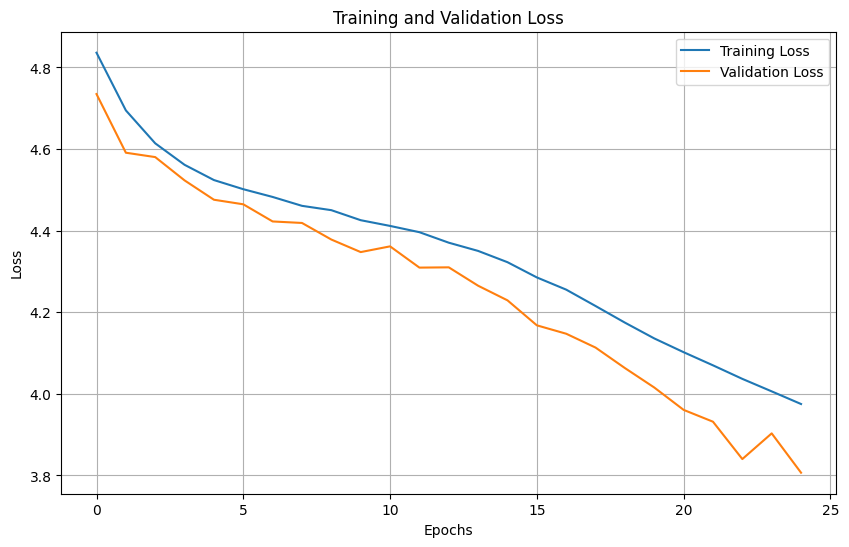

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.evaluate(X_test,y_test)

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1038 - loss: 3.9973


[3.963960886001587, 0.11791044473648071]

In [ ]:
X_train= np.array(X_train)
y_train = np.array(y_train)
X_test= np.array(X_test)
y_test = np.array(y_test)
X_val= np.array(X_val)
y_val = np.array(y_val)

In [ ]:
y_train

array([ 9, 17, 79, ..., 75, 96, 15])

In [ ]:
import numpy as np

# Ensure y_train is a 1D array
if isinstance(y_train, np.ndarray):
    y_train_processed = y_train.flatten()
else:
    y_train_processed = np.array(y_train).flatten()

# Verify the number of unique classes
num_classes = len(np.unique(y_train_processed))
print(f"Number of classes: {num_classes}")

Number of classes: 134


In [ ]:
from xgboost import XGBClassifier

# Assuming y_train is the target variable

XGB_Classifier = XGBClassifier(
    use_label_encoder=False,  # Avoid deprecated warnings
    random_state=42,          # Ensure reproducibility
    learning_rate=0.05,       # Lower learning rate for stability
    n_estimators=500,         # More trees with a smaller learning rate
    max_depth=6,              # Balanced tree depth (to prevent overfitting)
    min_child_weight=2,       # Control for overfitting with dense 
    subsample=0.8,            # Use 80% of samples for training each tree 
    colsample_bytree=0.8,     # Use 80% of features for training each tree 
    reg_alpha=0.1,            # L1 regularization (sparsity control) 
    reg_lambda=1.0,           # L2 regularization (shrinkage control) 
    verbosity=2,              # Show warnings and basic logs 
    objective="multi:softprob",  # Multi-class classification
    num_class=num_classes,    # Set the number of output classes
    early_stopping_rounds=10
)
# Fit the model
XGB_Classifier.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Monitor train/test metrics
    verbose=True  # Show progress
)

In [ ]:
# Fit the model
XGB_Classifier.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Monitor train/test metrics
    verbose=True  # Show progress
)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [07:49:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:4.75932	validation_1-mlogloss:4.81168
[1]	validation_0-mlogloss:4.61858	validation_1-mlogloss:4.72649
[2]	validation_0-mlogloss:4.48488	validation_1-mlogloss:4.64233
[3]	validation_0-mlogloss:4.35431	validation_1-mlogloss:4.56044
[4]	validation_0-mlogloss:4.22926	validation_1-mlogloss:4.48331
[5]	validation_0-mlogloss:4.10811	validation_1-mlogloss:4.41288
[6]	validation_0-mlogloss:3.99201	validation_1-mlogloss:4.34727
[7]	validation_0-mlogloss:3.87964	validation_1-mlogloss:4.28105
[8]	validation_0-mlogloss:3.77285	validation_1-mlogloss:4.21876
[9]	validation_0-mlogloss:3.66751	validation_1-mlogloss:4.15899
[10]	validation_0-mlogloss:3.56705	validation_1-mlogloss:4.10450
[11]	validation_0-mlogloss:3.47153	validation_1-mlogloss:4.05226
[12]	validation_0-mlogloss:3.37904	validation_1-mlogloss:4.00319
[13]	validation_0-mlogloss:3.28953	validation_1-mlogloss:3.95502
[14]	validation_0-mlogloss:3.20349	validation_1-mlogloss:3.91008
[15]	validation_0-mlogloss:3.11942	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=134,
              num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = XGB_Classifier.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5228855721393035
Classification Report:
               precision    recall  f1-score   support

           0       0.13      0.09      0.11        34
           1       0.61      0.59      0.60        34
           2       0.10      0.21      0.14        14
           3       0.18      0.08      0.11        36
           4       0.54      0.37      0.44        35
           5       0.70      0.77      0.73        30
           6       0.91      0.91      0.91        32
           7       0.72      0.93      0.81        42
           8       0.45      0.39      0.42        36
           9       0.58      0.60      0.59        30
          10       0.03      0.03      0.03        33
          11       0.78      0.81      0.79        26
          12       0.63      0.73      0.68        26
          13       0.37      0.55      0.44        20
          14       0.60      0.69      0.64        26
          15       0.71      0.92      0.80        26
          16       0.36     

In [ ]:
log_file = "/home/azureuser/cloudfiles/code/Users/YKhalifa/LOGS/Dlearn_model_evaluation_log_True.txt"

# Write the metrics to the log file
with open(log_file, "w") as f:
    f.write(f"Accuracy: {logs}\n\n")

print(f"Evaluation metrics saved to {log_file}")

Evaluation metrics saved to /home/azureuser/cloudfiles/code/Users/YKhalifa/LOGS/Dlearn_model_evaluation_log_True.txt


In [ ]:
import pickle

# Save the model
with open("Deep_model.pkl", "wb") as f:
    pickle.dump(model, f)
print("Model saved to Deep_model.pkl")

Model saved to Deep_model.pkl


In [ ]:
model.save(r'/home/azureuser/cloudfiles/code/Users/YKhalifa/Models Export/Deep Learning/LSTM_MODEL_ft.keras')

In [46]:
import pandas as pd
df = pd.read_csv(r"/home/azureuser/cloudfiles/code/Balanced_DS.csv")

In [ ]:
df = df[['PROBLEM_CODE', 'PROBLEM_SUMMARY']]

In [51]:
df.to_csv("Balanced_DS.csv")